In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In [9]:
TARGETS = ['AB42_AB40Positivity', 'tTau_AB42Positivity', 'pTau_Positivity']

MOCA = ['MOCATOTS']
CRAFT = ['CRAFTVRS', 'CRAFTURS', 'CRAFTDVR', 'CRAFTDRE']
FLUENCY_FL = ['UDSVERFC', 'UDSVERLC']
FLUENCY_AV = ['ANIMALS', 'VEG']
TRAIL = ['TRAILA', 'TRAILB']
SPAN_F = ['DIGFORCT', 'DIGFORSL']
SPAN_B = ['DIGBACCT', 'DIGBACLS']

TASKS =  [
    (MOCA+CRAFT+FLUENCY_AV+FLUENCY_FL+TRAIL+SPAN_B+SPAN_F, 'All'),
    (MOCA, 'T-MoCa'), 
    (CRAFT, 'Craft Story'), 
    (TRAIL, 'Oral Trail Making'), 
    (FLUENCY_FL + FLUENCY_AV, 'Verbal Fluency'), 
    (FLUENCY_FL, 'Verbal Fluency\n(F & L)'),
    (FLUENCY_AV, 'Verbal Fluency\n(Animals & Vegetables)'),
    (SPAN_B + SPAN_F, 'Number Span'),
    (SPAN_F, 'Number Span\n(Forward)'),
    (SPAN_B, 'Number Span\n(Backward)')
]

In [10]:
def load_raw_data(feats: list[str], target: str):
    # Load the entire csv file
    data = pd.read_csv('data/labels.csv')[['id'] + feats + [target]]
    data[target] = data[target].map(lambda x: np.nan if x==' ' else x)

    data = data.dropna()
    data[target] = data[target].astype(int)

    # Extract only the ground truths
    labels = pd.DataFrame(data[target], columns=[target])
    data = data.drop(target, axis=1)

    data = data.set_index('id')

    return data.reset_index(), labels.reset_index()[target]

In [11]:
def analyze(feats, task, runs=10):
    bar = tqdm(range(runs))
    bar.set_description(task.replace('\n', ' ') + ' '*(37-len(task)))
    
    means, stdevs = {}, {}
    partial = {target: [] for target in TARGETS}
    for _ in bar:
        for target in TARGETS:
            loo = LeaveOneOut()
            ys_true, ys_pred = [], []
            
            X, y = load_raw_data(feats, target)
            for train_index, test_index in loo.split(X):
                model = RandomForestClassifier(n_estimators = 100)
                model.fit(X.iloc[train_index], y.iloc[train_index])

                ys_pred.append(model.predict(X.iloc[test_index])[0])
                ys_true.append(y.iloc[test_index].values[0])

            partial[target].append(
                (accuracy_score(ys_pred, ys_true),
                 f1_score(ys_pred, ys_true),
                 roc_auc_score(ys_pred, ys_true))
            )
    for target in TARGETS:
        accs, f1s, rocs = zip(*partial[target])
        means[target] = {
            'Accuracy': np.mean(accs),
            'F1 Score': np.mean(f1s),
            'ROC-AUC':  np.mean(rocs)
        }
        stdevs[target] = {
            'Accuracy': np.std(accs),
            'F1 Score': np.std(f1s),
            'ROC-AUC':  np.std(rocs)
        }
    return means, stdevs
         

In [12]:
def plot(means: dict[str, dict[str, dict[str, float]]], stdevs: dict[str, dict[str, dict[str, float]]]):
    for metric in ['ROC-AUC', 'F1 Score', 'Accuracy']:
        to_visualize = {'index': []}
        to_print = {'index': []}
        for cog_task in means.keys():
            to_visualize['index'].append(cog_task)
            to_print['index'].append(cog_task.replace('\n', ' '))
            by_target = means[cog_task]
            for target in by_target.keys():
                if target not in to_visualize:
                    to_visualize[target] = []
                    to_print[target] = []
                to_visualize[target].append(means[cog_task][target][metric])
                to_print[target].append(f'{means[cog_task][target][metric]:0.4f} +- {stdevs[cog_task][target][metric]:0.4f}')

        df = pd.DataFrame(to_visualize)
        fig, ax = plt.subplots(1, 3, figsize=(12,4))
        fig.tight_layout(w_pad=10, h_pad=4)
        plt.suptitle(metric, y=1.04, fontsize=16)
        for idx, target in enumerate(TARGETS):
            b = sns.barplot(df, x=target, y='index', orient='h', ax=ax[idx])
            b.set(xlabel=target, ylabel=None)
        plt.show()
        display(pd.DataFrame(to_print))
        print('*'*100)
     

In [13]:
data_mean, data_stdevs = {}, {}
for feats, task in TASKS:
    data_mean[task], data_stdevs[task] = analyze(feats, task)

Number Span (Backward)               : 100%|██████████| 10/10 [03:46<00:00, 22.61s/it]


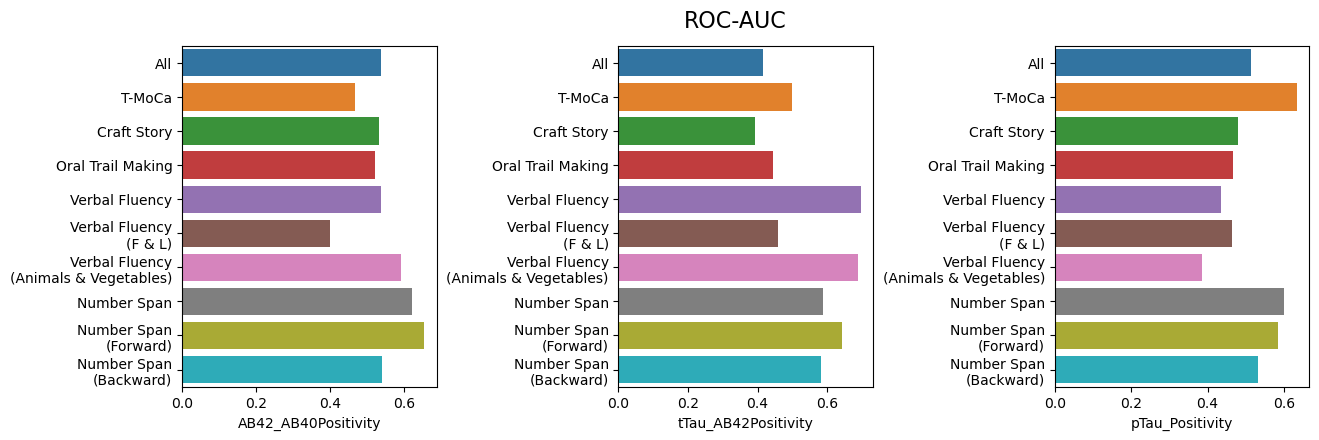

,index,AB42_AB40Positivity,tTau_AB42Positivity,pTau_Positivity
0,All,0.5385 +- 0.0449,0.4154 +- 0.0518,0.5137 +- 0.0430
1,T-MoCa,0.4677 +- 0.0123,0.4998 +- 0.0098,0.6341 +- 0.0163
2,Craft Story,0.5329 +- 0.0184,0.3914 +- 0.0200,0.4796 +- 0.0189
3,Oral Trail Making,0.5218 +- 0.0250,0.4442 +- 0.0340,0.4663 +- 0.0278
4,Verbal Fluency,0.5391 +- 0.0412,0.6968 +- 0.0440,0.4343 +- 0.0255
5,Verbal Fluency (F & L),0.3999 +- 0.0259,0.4584 +- 0.0396,0.4646 +- 0.0253
6,Verbal Fluency (Animals & Vegetables),0.5919 +- 0.0382,0.6892 +- 0.0247,0.3865 +- 0.0339
7,Number Span,0.6225 +- 0.0327,0.5880 +- 0.0510,0.5995 +- 0.0421
8,Number Span (Forward),0.6562 +- 0.0254,0.6425 +- 0.0292,0.5847 +- 0.0215
9,Number Span (Backward),0.5419 +- 0.0148,0.5816 +- 0.0174,0.5310 +- 0.0222


****************************************************************************************************


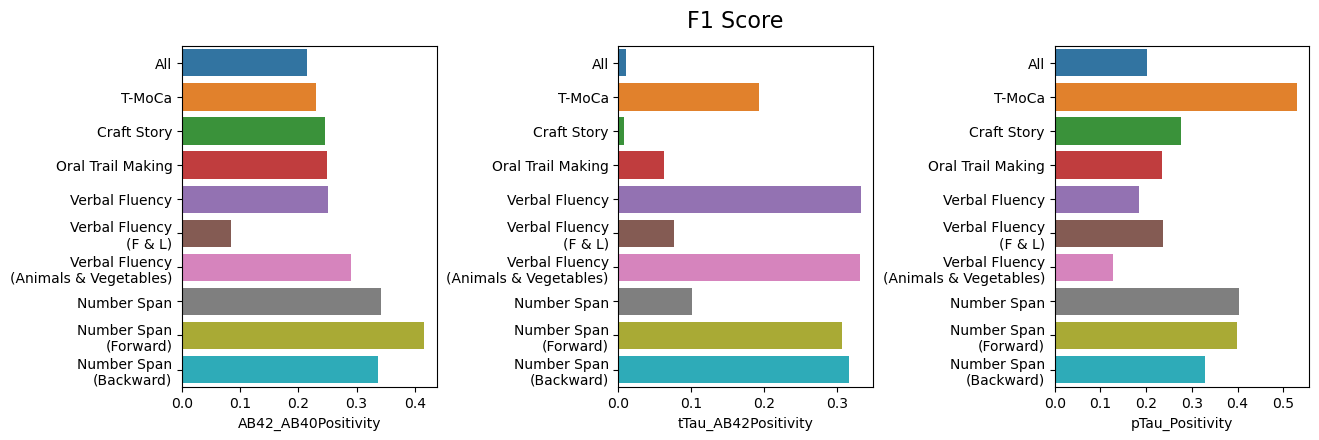

,index,AB42_AB40Positivity,tTau_AB42Positivity,pTau_Positivity
0,All,0.2140 +- 0.0449,0.0111 +- 0.0333,0.2020 +- 0.0349
1,T-MoCa,0.2303 +- 0.0121,0.1925 +- 0.0066,0.5301 +- 0.0236
2,Craft Story,0.2449 +- 0.0223,0.0080 +- 0.0240,0.2761 +- 0.0255
3,Oral Trail Making,0.2490 +- 0.0374,0.0621 +- 0.0407,0.2338 +- 0.0300
4,Verbal Fluency,0.2512 +- 0.0576,0.3325 +- 0.0132,0.1849 +- 0.0288
5,Verbal Fluency (F & L),0.0840 +- 0.0276,0.0758 +- 0.0439,0.2360 +- 0.0304
6,Verbal Fluency (Animals & Vegetables),0.2905 +- 0.0487,0.3308 +- 0.0082,0.1266 +- 0.0471
7,Number Span,0.3415 +- 0.0462,0.1012 +- 0.0038,0.4039 +- 0.0548
8,Number Span (Forward),0.4166 +- 0.0305,0.3073 +- 0.0244,0.3987 +- 0.0315
9,Number Span (Backward),0.3375 +- 0.0240,0.3167 +- 0.0275,0.3286 +- 0.0373


****************************************************************************************************


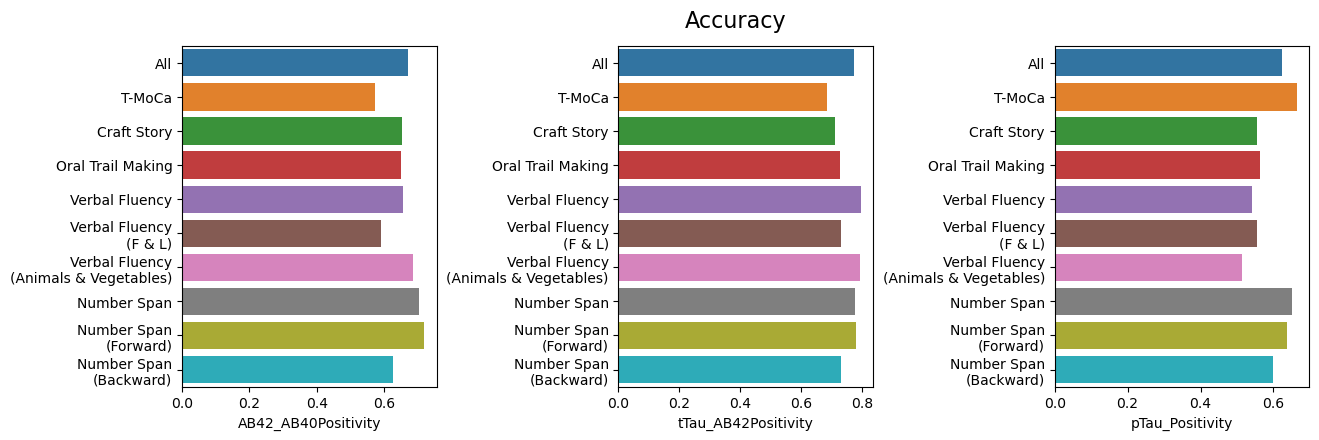

,index,AB42_AB40Positivity,tTau_AB42Positivity,pTau_Positivity
0,All,0.6724 +- 0.0253,0.7737 +- 0.0115,0.6225 +- 0.0250
1,T-MoCa,0.5738 +- 0.0153,0.6850 +- 0.0135,0.6649 +- 0.0146
2,Craft Story,0.6537 +- 0.0126,0.7100 +- 0.0109,0.5541 +- 0.0148
3,Oral Trail Making,0.6494 +- 0.0164,0.7286 +- 0.0108,0.5625 +- 0.0250
4,Verbal Fluency,0.6557 +- 0.0232,0.7962 +- 0.0119,0.5411 +- 0.0186
5,Verbal Fluency (F & L),0.5912 +- 0.0217,0.7312 +- 0.0084,0.5541 +- 0.0218
6,Verbal Fluency (Animals & Vegetables),0.6861 +- 0.0168,0.7949 +- 0.0076,0.5151 +- 0.0164
7,Number Span,0.7025 +- 0.0166,0.7775 +- 0.0094,0.6500 +- 0.0299
8,Number Span (Forward),0.7200 +- 0.0150,0.7800 +- 0.0115,0.6378 +- 0.0158
9,Number Span (Backward),0.6275 +- 0.0109,0.7312 +- 0.0151,0.5986 +- 0.0136


****************************************************************************************************


In [14]:
plot(data_mean, data_stdevs)